# Машинное обучение, ФКН ВШЭ

## Практическое задание 2. Exploratory Data Analysis и линейная регрессия

### Общая информация
Дата выдачи: 26.09.2021

Мягкий дедлайн: 23:59MSK 11.10.2021

Жесткий дедлайн: 23:59MSK 14.10.2021

В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [469]:
!pip install folium

In [470]:
!pip install seaborn

In [1200]:
import folium

m = folium.Map(location=(55.7522200, 37.6155600), zoom_start=10)

m

Если вы всё сделали правильно, то выше должна открыться карта Москвы.

In [1201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error


%matplotlib inline
sns.set(style="darkgrid")

## Часть 0. Подготовка (1 балл)

**Задание 1 (1 балл)**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [1202]:
df = pd.read_csv('train.csv')
trip_duration = df['trip_duration']

Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [1203]:
df.drop('dropoff_datetime', axis=1, inplace=True)
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

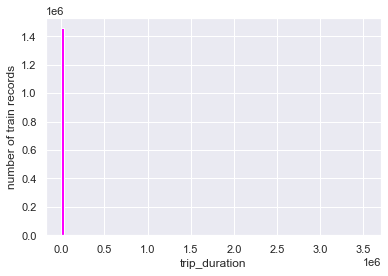

In [1204]:
plt.hist(df['trip_duration'].values, bins=100, color="magenta")
plt.xlabel('trip_duration')
plt.ylabel('number of train records')
plt.show()

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

**Ответ**: В данных есть выбросы (есть слишком большие значения целевой переменной)

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

**Ответ**: Если мы сделаем один очень плохой прогноз, возведение в квадрат сделает ошибку еще хуже (MSE), и это может исказить метрику в сторону переоценки плохости модели. RMSLE больше чувствителен к выбросам



**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**: RMSE - квадратный корень из MSE. Квадратный корень введен, чтобы масштаб ошибок был таким же, как масштаб целей

$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2} = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\hat{y}_i - \hat{a}(x_i)\big)^2} = \text{RMSE}(X, \hat{y}, \hat{a})$$

Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте **гистограмму модифицированного таргета по обучающей выборке**. Удалите колонку со старым таргетом.

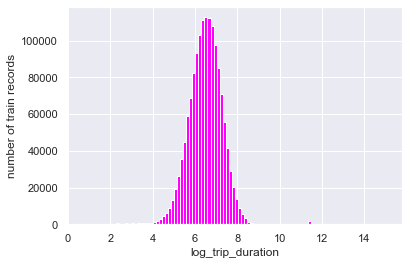

In [1205]:
df['log_trip_duration'] = np.log1p(df['trip_duration'].values)
plt.hist(df['log_trip_duration'].values, bins=100, color='magenta')
plt.xlabel('log_trip_duration')
plt.ylabel('number of train records')
plt.show()

In [1206]:
df.drop('trip_duration', axis=1)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,log_trip_duration
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,6.122493
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,6.498282
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,7.661527
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,6.063785
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,6.077642
...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,4,-73.982201,40.745522,-73.994911,40.740170,N,6.658011
1458640,id1049543,1,2016-01-10 07:35:15,1,-74.000946,40.747379,-73.970184,40.796547,N,6.486161
1458641,id2304944,2,2016-04-22 06:57:41,1,-73.959129,40.768799,-74.004433,40.707371,N,6.639876
1458642,id2714485,1,2016-01-05 15:56:26,1,-73.982079,40.749062,-73.974632,40.757107,N,5.924256


Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [1207]:
mse = metrics.mean_squared_error(np.mean(df['log_trip_duration']) * np.ones(df.shape[0]), df['log_trip_duration'])
mse = np.sqrt(mse)
mse

0.7957592365411509

## Часть 1. Изучаем `pickup_datetime` (2 балла)

**Задание 2 (0.25 баллов)**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться `sns.countplot`):

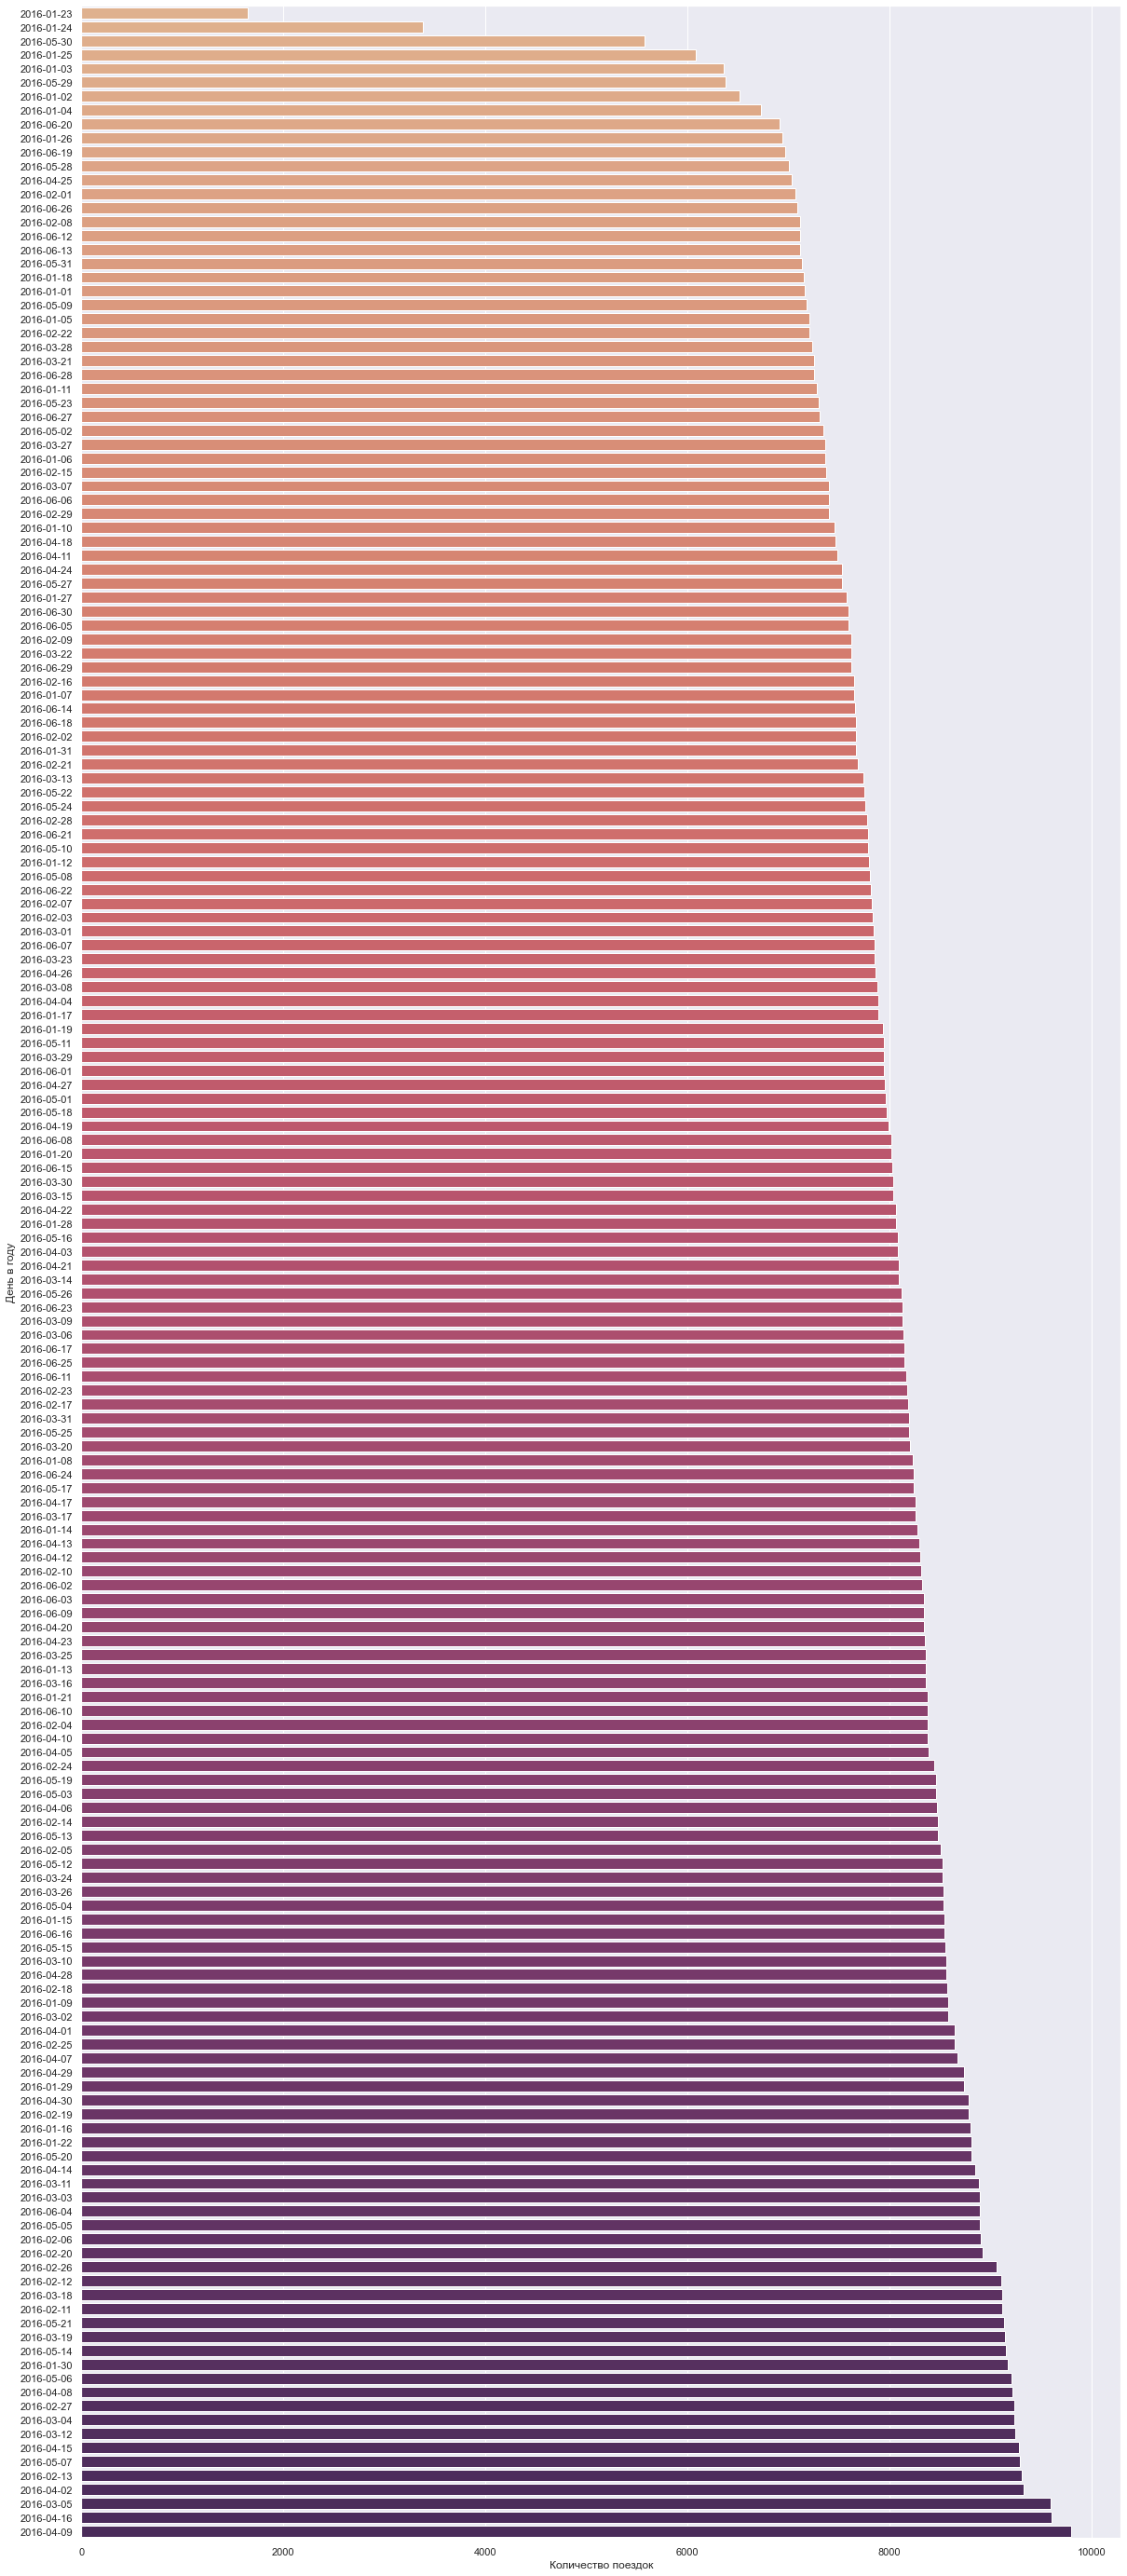

In [1208]:
plt.figure(figsize = (20,50))
dates = df['pickup_datetime'].dt.date
plot = sns.countplot(y=dates, data=df, order=dates.value_counts(ascending=True).index, palette="flare")
plt.xlabel('Количество поездок')
plt.ylabel('День в году')
plt.show()

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

**Ответ**:

**1**: 23-24 января. 23 января - В Нью-Йорке введен запрет на использование мостов, туннелей и дорог, заявил губернатор штата Эндрю Куомо. 23-24 января там была снежная буря (так же 25 января все еще мало пользовались транспортом из-за проблем с погодгными условиями)

**2**: 29-30 мая. Ничего не происходило чрезвычайное, возможно из-за праздника memorial day (30 may)


**Графики зависимости количества поездок от дня недели**

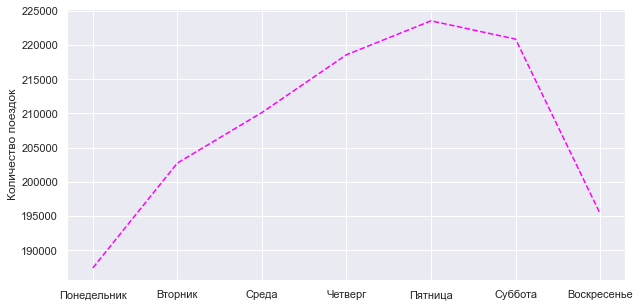

In [1209]:
plt.figure(figsize = (10,5))
weekday = df.groupby(df['pickup_datetime'].dt.weekday)['id'].count()
ax = sns.lineplot(data=pd.DataFrame(weekday), y='id', x='pickup_datetime',color='magenta')
ax.lines[0].set_linestyle("--")
plt.xlabel('')
plt.ylabel('Количество поездок')
plt.xticks(range(0, 7), ('Понедельник','Вторник','Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье'))
plt.show()

**Графики зависимости количества поездок от часов в сутках**

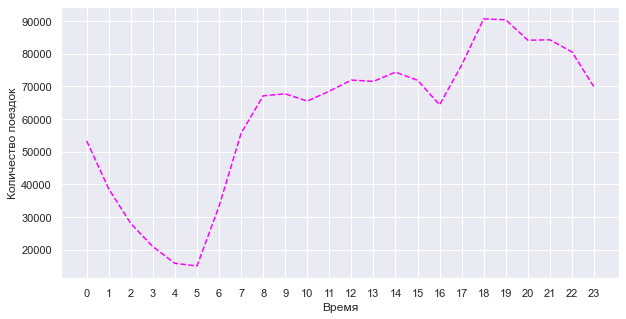

In [1210]:
plt.figure(figsize = (10,5))
hours = df.groupby(df['pickup_datetime'].dt.hour)['id'].count()
ax = sns.lineplot(data=pd.DataFrame(hours), y='id', x='pickup_datetime',color='magenta')
ax.lines[0].set_linestyle("--")
plt.ylabel('Количество поездок')
plt.xlabel('Время')
plt.xticks(range(24))
plt.show()

**Задание 3 (0.5 баллов)**. **Зависимость количества поездок от часа дня в разные месяцы**

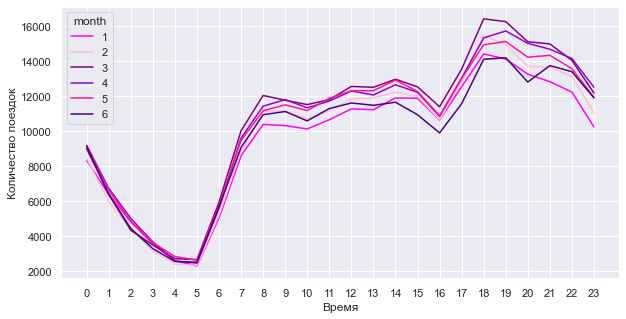

In [1211]:
plt.figure(figsize = (10,5))
months = pd.DataFrame(df.groupby([df['pickup_datetime'].dt.month, df['pickup_datetime'].dt.hour])['id'].count())
months.index = months.index.rename(['month', 'hours'])
months.reset_index(inplace=True)
sns.lineplot(data=months, y='id', x='hours', hue='month', palette=['magenta', 'pink', 'purple', 'darkviolet', 'deeppink', 'indigo'])
plt.xlabel('Время')
plt.ylabel('Количество поездок')
plt.xticks(range(24))
plt.show()

**Зависимость количества поездок от часа дня в разные дни недели**

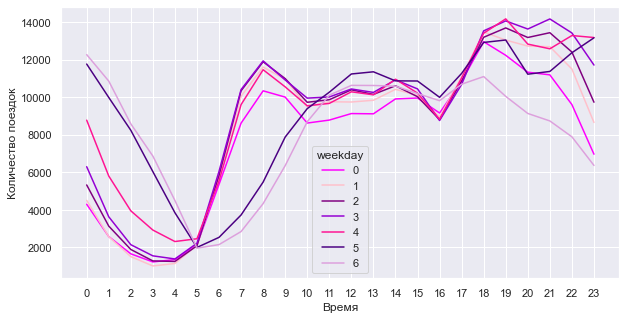

In [1212]:
plt.figure(figsize = (10,5))
weekdays = pd.DataFrame(df.groupby([df['pickup_datetime'].dt.weekday, df['pickup_datetime'].dt.hour])['id'].count())
weekdays.index = weekdays.index.rename(['weekday', 'hours'])
weekdays.reset_index(inplace=True)
sns.lineplot(data=weekdays, y='id', x='hours', hue='weekday',  palette=['magenta', 'pink', 'purple', 'darkviolet', 'deeppink', 'indigo', 'plum'])
plt.xlabel('Время')
plt.ylabel('Количество поездок')
plt.xticks(range(24))
plt.show()


**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

**Ответ**: Зависимость от месяца: c 0:00 до 5:00 спрос падаем тк люди спят. с 5:00 спрос растет тк людям на работу/учебу. Дальше с 7:00 до 16:00 спрос не меняется тк люди на учебе/работе. С 16:00 до 18:00 спрос растет тк люди уезжают с работы/учебы. После 18:00 спрос немного падает, но так же высок тк люди уже свободны едут по своим делам отдыхать))

Зависимость от дня недели: По будням с 0:00 до 5:00 спрос более резко падает тк люди спят перед работой, а на выходных не так резко падает тк люди возвращаются из баров/клубов. По будням с 5:00 до 8:00 спрос резко растет тк люди едут на работу, а по выходным спрос плавно растет с 5:00 до 12:00 тк в выходной день можно выспаться. По будням с 8:00 до 16:00 спрос примерно не меняется тк люди на учебе/работе. По выходным спро с 12:00 уже почти не менеятся и начинает очень плавно падать после 18 часов. По будням с 16:00 до 18:00 спрос растет тк люди возвращаются с работы, а потом плавно падает тк они уже после своих дел после работы окончательно домой возвращаются. 

**Задание 4 (0.5 баллов)**. Разбейте выборку на обучающую и тестовую в отношении 7:3. По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

In [1213]:
train, test = train_test_split(df, test_size=0.3, random_state=10)

**График зависимости среднего логарифма времени поездки от дня недели**

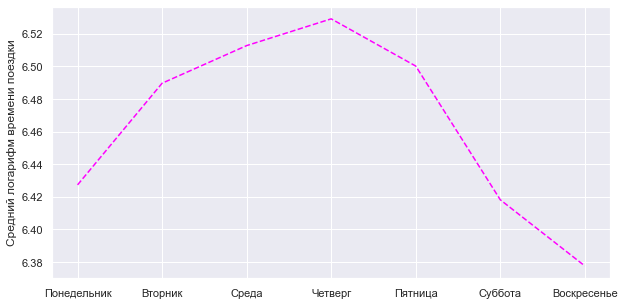

In [1214]:
plt.figure(figsize = (10,5))
weekdays = pd.DataFrame(train.groupby(train['pickup_datetime'].dt.weekday)['log_trip_duration'].mean())
weekdays.reset_index(inplace=True)
ax = sns.lineplot(data=weekdays, y='log_trip_duration', x='pickup_datetime', color='magenta')
ax.lines[0].set_linestyle("--")
plt.ylabel('Средний логарифм времени поездки')
plt.xlabel('')
plt.xticks(range(0, 7), ('Понедельник','Вторник','Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье'))
plt.show()

**График зависимости среднего логарифма времени поездки от часа дня**

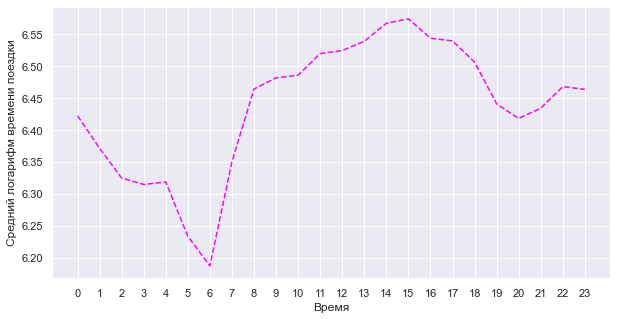

In [1215]:
plt.figure(figsize = (10,5))
hours = pd.DataFrame(train.groupby(train['pickup_datetime'].dt.hour)['log_trip_duration'].mean())
hours.reset_index(inplace=True)
ax = sns.lineplot(data=hours, y='log_trip_duration', x='pickup_datetime', color='magenta')
ax.lines[0].set_linestyle("--")
plt.xticks(range(24))
plt.ylabel('Средний логарифм времени поездки')
plt.xlabel('Время')
plt.show()

**График зависимости логарифма времени поездки от дня года**

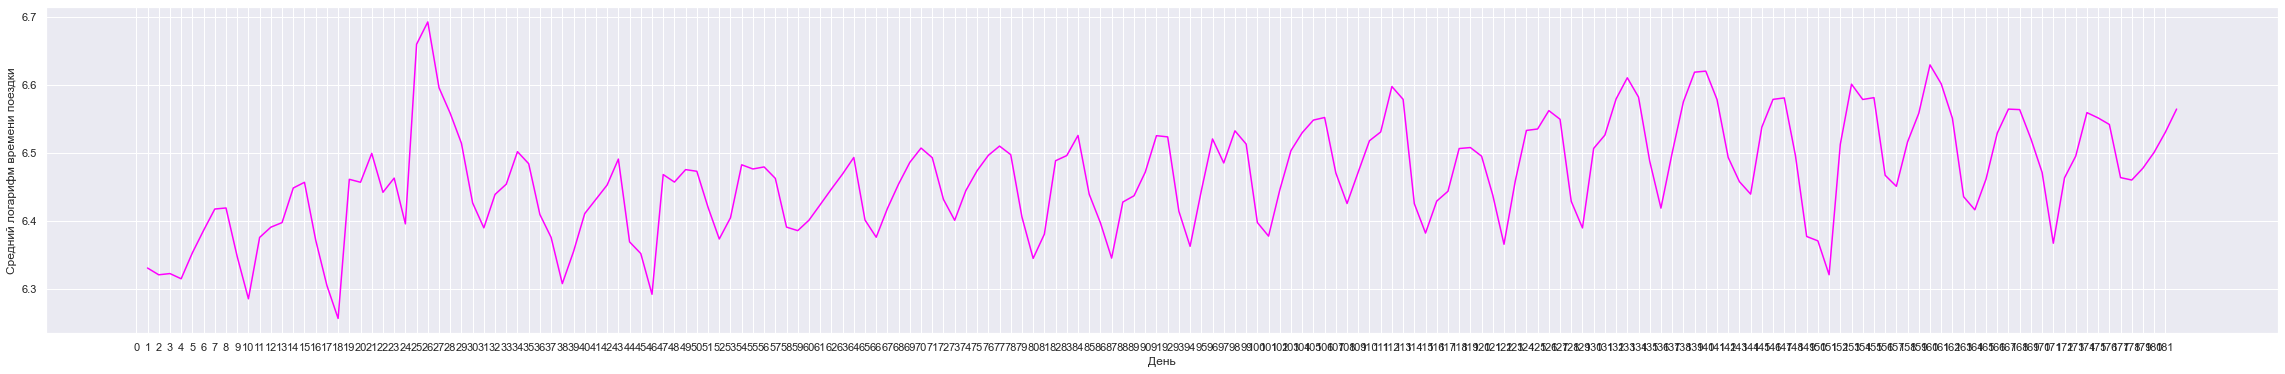

In [1216]:
plt.figure(figsize = (40,6))
days_in_year = pd.DataFrame(train.groupby(train['pickup_datetime'].dt.dayofyear)['log_trip_duration'].mean())
days_in_year.reset_index(inplace=True)
sns.lineplot(data=days_in_year, y='log_trip_duration', x='pickup_datetime', color='magenta')
plt.xticks(range(182))
plt.xlabel('День')
plt.ylabel('Средний логарифм времени поездки')

plt.show()

**График зависимости логарифма времени поездки от месяца чтобы убедиться что есть зависимость**


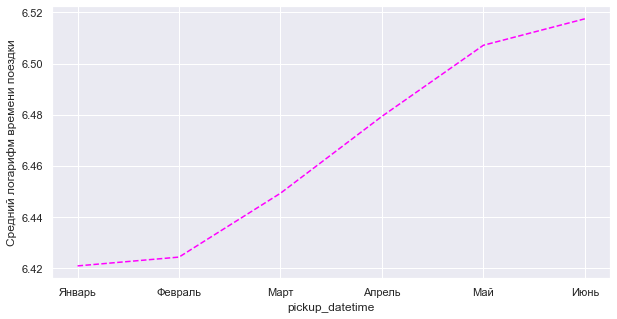

In [1217]:
plt.figure(figsize = (10,5))
months = pd.DataFrame(train.groupby(train['pickup_datetime'].dt.month)['log_trip_duration'].mean())
months.reset_index(inplace=True)
ax = sns.lineplot(data=months, y='log_trip_duration', x='pickup_datetime', color='magenta')
ax.lines[0].set_linestyle("--")
plt.xticks(range(1, 7), ('Январь','Февраль','Март', 'Апрель', 'Май', 'Июнь'))
plt.ylabel('Средний логарифм времени поездки')
plt.show()

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

**Ответ**:
1. Графики похожи, потому что если больше поездок в определенное время то увеличивается загруженность на дорогах в это время, а следовательно увеличивается продолжительность поездки из-за повешенного трафика

2. 23-24 января поездки занимали гораздо больше времени по сравнению с поездками в выходные. В течении нескольких дней после этого периода дороги были заснежены, что затрудняло движения --> поездки были гораздо дольше.30 мая поездки занимали гораздо меньше времени по сравнению с другими понедельниками. Это может быть связано с тем, что в основном люди оставались дома в праздник, поэтому поездки из-за незагруженность дорог занимали гораздо меньше времени

3. Среднее поездки минимально в каждую субботу и воскресенье и возрастает до максимума в четверг-пятницу. Это может быть связано с тем, что на выходные (в чт-пт) люди уезжают загород или остаются дома. Среднее время поездки растет относительно месяцев. 

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [1218]:
train.loc[:,'weekday'] = train['pickup_datetime'].dt.weekday
train.loc[:,'month'] = train['pickup_datetime'].dt.month
train.loc[:,'hour'] = train['pickup_datetime'].dt.hour
train.loc[:,'day'] = train['pickup_datetime'].dt.dayofyear
train.loc[:,'is_snow'] = ((train['day'] == 23) | (train['day'] == 24)).apply(lambda x: 1 if x else 0)
train.loc[:,'is_memorial'] = (train['day'] == 151).apply(lambda x: 1 if x else 0)

test.loc[:,'weekday'] = test['pickup_datetime'].dt.weekday
test.loc[:,'month'] = test['pickup_datetime'].dt.month
test.loc[:,'hour'] = test['pickup_datetime'].dt.hour
test.loc[:,'day'] = test['pickup_datetime'].dt.dayofyear
test.loc[:,'is_snow'] = ((test['day'] == 23) | (test['day'] == 24)).apply(lambda x: 1 if x else 0)
test.loc[:,'is_memorial'] = (test['day'] == 151).apply(lambda x: 1 if x else 0)



/Users/varya/miniforge3/envs/hseml/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков стоит рассматривать как категориальные, а какие - как численные? Почему?

**Ответ**: Бинарные признаки рассматриваем как численные, потому что нет необходимости их кодировать с помощью OneHotEncoder. Еще численым можно рассматривать признак month потому что как выяснилось в задании выше: существует зависимости логарифма времени поездки от месяца, которая почти линейная. День в году - day делаем котегориальным признаком так как  линейной зависимости не прослеживается и явный порядок тоже задать на значениях признака (влиляющий на целевую переменную) нельзя. Однако, замеченная на графике 'сезонность' по сути закодирована в признаке weekday, поэтому, я думаю, что если удалить этот признак из данных то качество не должно сильно измениться,  день недели - weekday и часы - hour рассматриваем как категориальный так-как нет никакой линейной зависимости. 

**Задание 5 (0.75 баллов)**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [1219]:
stsc = StandardScaler()
ohe = OneHotEncoder()
ohe_h = OneHotEncoder()

x = train[['is_snow', 'month', 'is_memorial']].reset_index().drop('index', axis=1)

StandardScal = pd.DataFrame(stsc.fit_transform(train[['is_snow', 'month', 'is_memorial']]))
StandardScal.columns = ['is_snow', 'month', 'is_memorial']

y = test[['is_snow', 'month', 'is_memorial']].reset_index().drop('index', axis=1)

StandardScal = pd.DataFrame(stsc.transform(test[['is_snow', 'month', 'is_memorial']]))
StandardScal.columns = ['is_snow', 'month', 'is_memorial']

ohe_h = pd.DataFrame(ohe.fit_transform(train[['hour', 'weekday', 'day']]).toarray())
ohe_test = pd.DataFrame(ohe.transform(test[['hour', 'weekday', 'day']]).toarray())

In [1220]:
x = x.join(ohe_h)
x1 = train['log_trip_duration']
y = y.join(ohe_test)
y1 = test['log_trip_duration']

In [1221]:
mod = Ridge()
mod.fit(x, x1)
y_pred = mod.predict(y)
print("MSE = %.4f" % mean_squared_error(y1, y_pred))
print("RMSE = %.4f" % mean_squared_error(y1, y_pred, squared=False))

MSE = 0.6185
RMSE = 0.7865


## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [1222]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [1223]:
show_circles_on_map(df.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [1224]:
show_circles_on_map(df.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

**Вопрос**: Какие две точки выделяются на карте?

**Ответ**: Помимо Манхетенна выделяются 2 точки -- John F. Kennedy International Airport и LaGuardia Airport

**Задание 6 (0.75 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Также можно воспользоваться кодом с первого семинара. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [1225]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b
df.loc[:, 'haversine'] = haversine_array(df['pickup_latitude'].values, df['pickup_longitude'].values, df['dropoff_latitude'].values, df['dropoff_longitude'].values)

Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку:

In [1226]:
df['log_haversine'] = np.log1p(df['haversine'])
df.head(5)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,haversine,log_haversine
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455,6.122493,1.498521,0.915699
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6.498282,1.805507,1.031584
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,7.661527,6.385098,1.999464
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429,6.063785,1.485498,0.910473
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435,6.077642,1.188588,0.783257


Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:
Убудились, потому что между ними корреляция больше

In [1227]:
correlation = df[['log_trip_duration', 'haversine', 'log_haversine']].corr()
correlation

,log_trip_duration,haversine,log_haversine
log_trip_duration,1.000000,0.573595,0.749882
haversine,0.573595,1.000000,0.844501
log_haversine,0.749882,0.844501,1.000000


**Задание 7 (0.75 балла)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

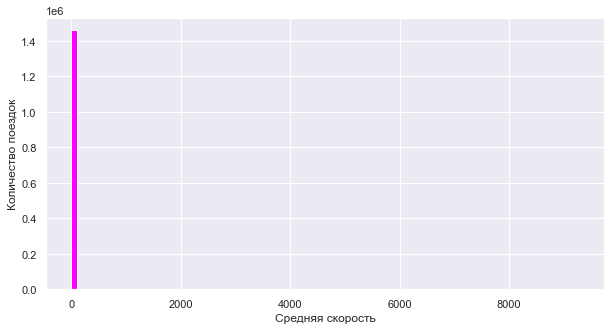

In [1228]:
plt.figure(figsize = (10,5))
df['mean_speed'] = df['haversine'] / trip_duration * 3600
plt.hist(df['mean_speed'].values, bins=100, color='magenta')
plt.xlabel('Cредняя скорость')
plt.ylabel('Количество поездок')
plt.show()

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

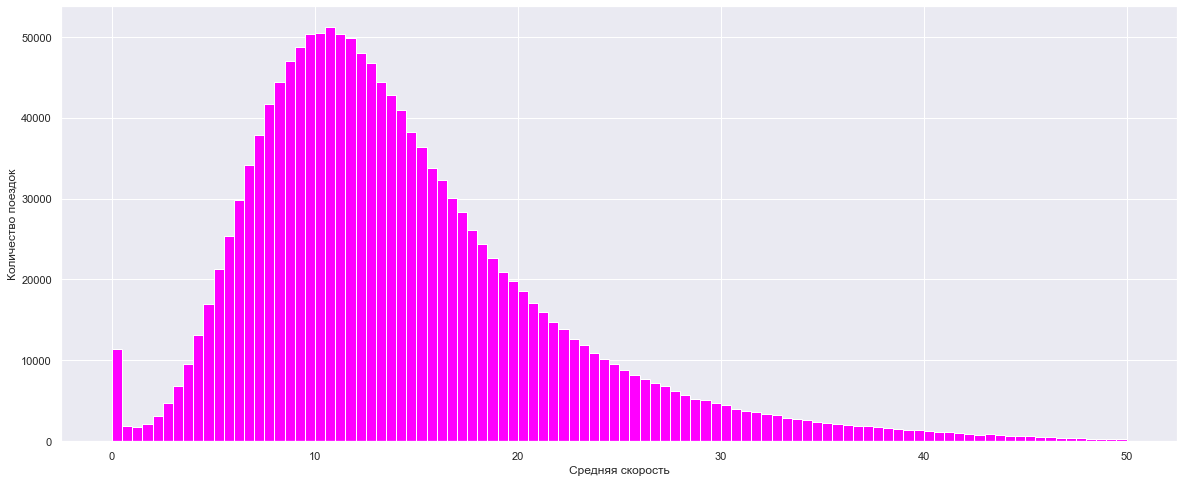

In [1229]:
plt.figure(figsize = (20,8))
plt.hist(df[df.mean_speed < 50]['mean_speed'].values, bins=100, color = 'magenta')
plt.xlabel('Cредняя скорость')
plt.ylabel('Количество поездок')
plt.show()

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

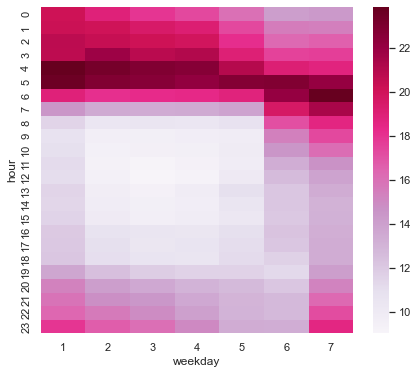

In [1230]:
plt.figure(figsize = (7,6))
heat_map = pd.DataFrame(df.groupby([df['pickup_datetime'].dt.hour, df['pickup_datetime'].dt.weekday])['mean_speed'].median())
heat_map.index.rename(['hour', 'weekday'], inplace=True)     
heat_map.reset_index(inplace=True)
heat_map['weekday'] += 1
t = heat_map.pivot(index='hour', columns='weekday', values='mean_speed')
sns.heatmap(t, cmap="PuRd")
plt.xlabel("weekday");

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

**Ответ**: Потому что на этапе предсказания модель не знает среднюю скорость пути, тк ее можно вычислить уже только после окончания поездки. 

In [1231]:
df.drop(['mean_speed'], axis=1, inplace=True)

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

In [1232]:
df['is_trafic'] = ((df['pickup_datetime'].dt.weekday < 5) \
                & ((df['pickup_datetime'].dt.hour > 6) \
                & (df['pickup_datetime'].dt.hour < 10)) \
                | ((df['pickup_datetime'].dt.hour > 16) \
                & (df['pickup_datetime'].dt.hour < 23))).apply(lambda x: 1 if x else 0)


In [1233]:
df['is_free'] = ((df['pickup_datetime'].dt.weekday > 4) \
            & (df['pickup_datetime'].dt.hour > 3) \
            & (df['pickup_datetime'].dt.hour < 8) \
            | (df['pickup_datetime'].dt.weekday < 5) \
            & (df['pickup_datetime'].dt.hour > 0) \
            & (df['pickup_datetime'].dt.hour < 5) ).apply(lambda x: 1 if x else 0)

**Задание 8 (0.25 балла)**. Как уже было замечено выше, на карте выделяются две точки вдали от Манхэттена. Для каждой из них добавьте в выборку два признака: началась ли поездка в ней и закончилась ли она в ней.

In [1234]:
df['pickup_lag'] = ((df['pickup_latitude'] <= 40.77600) \
                        & (df['pickup_latitude'] >= 40.76700) \
                        & (df['pickup_longitude'] >= -73.88800) \
                        & (df['pickup_longitude'] <= -73.86300)).apply(lambda x: 1 if x else 0)
df['dropoff_lag'] = ((df['dropoff_latitude'] <= 40.77600) \
                        & (df['dropoff_latitude'] >= 40.76700) \
                        & (df['dropoff_longitude'] >= -73.88800) \
                        & (df['dropoff_longitude'] <= -73.86300)).apply(lambda x: 1 if x else 0)

In [1235]:
df['pickup_ken'] = ((df['pickup_latitude'] <= 40.65000) \
                        & (df['pickup_latitude'] >= 40.63800) \
                        & (df['pickup_longitude'] >= -73.79400) \
                        & (df['pickup_longitude'] <= -73.77300)).apply(lambda x: 1 if x else 0)
df['dropoff_ken'] = ((df['dropoff_latitude'] <= 40.65000) \
                        & (df['dropoff_latitude'] >= 40.63800) \
                        & (df['dropoff_longitude'] >= -73.79400) \
                        & (df['dropoff_longitude'] <= -73.77300)).apply(lambda x: 1 if x else 0)

Для каждого из созданных признаков нарисуйте "ящик с усами" (`sns.boxplot`) распределения логарифма времени поездки

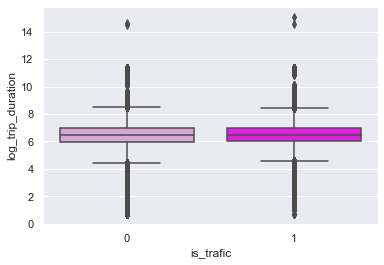

In [1236]:
ax = sns.boxplot(x='is_trafic', y="log_trip_duration", data=df, palette = ['plum', 'magenta'])

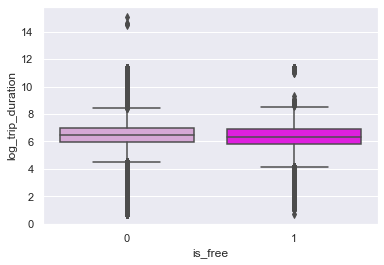

In [1237]:
ax = sns.boxplot(x='is_free', y="log_trip_duration", data=df, palette = ['plum', 'magenta'])

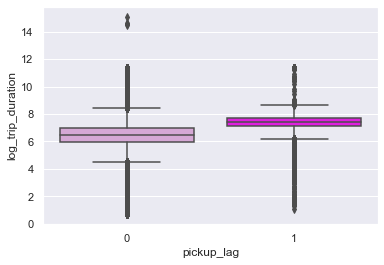

In [1238]:
ax = sns.boxplot(x='pickup_lag', y="log_trip_duration", data=df, palette = ['plum', 'magenta'])

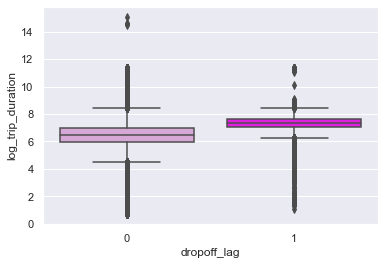

In [1239]:
ax = sns.boxplot(x='dropoff_lag', y="log_trip_duration", data=df, palette = ['plum', 'magenta'])

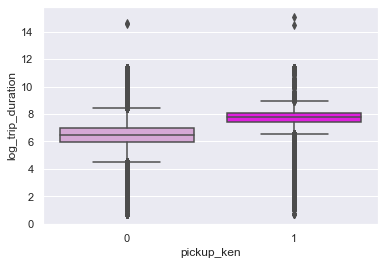

In [1240]:
ax = sns.boxplot(x='pickup_ken', y="log_trip_duration", data=df, palette = ['plum', 'magenta'])

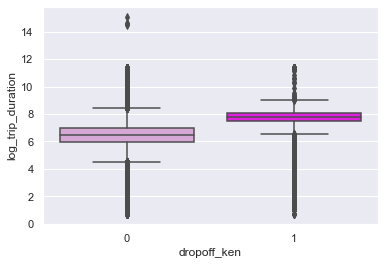

In [1241]:
ax = sns.boxplot(x='dropoff_ken', y="log_trip_duration", data=df, palette = ['plum', 'magenta'])

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

**Ответ**: cудя по графикам признаки связанные с аэропортами получились хорошие, а связанные с пробками/свободными дорогами плохие

In [1306]:
df.loc[:,'weekday'] = df['pickup_datetime'].dt.weekday
df.loc[:,'month'] = df['pickup_datetime'].dt.month
df.loc[:,'hour'] = df['pickup_datetime'].dt.hour
df.loc[:,'day'] = df['pickup_datetime'].dt.dayofyear
df.loc[:,'is_snow'] = ((df['day'] == 23) | (df['day'] == 24)).apply(lambda x: 1 if x else 0)
df.loc[:,'is_memorial'] = (df['day'] == 151).apply(lambda x: 1 if x else 0)

In [1307]:
st = StandardScaler()
oh = OneHotEncoder()
df_new = df.reset_index().drop('index', axis=1)
StandardScal = pd.DataFrame(st.fit_transform(df[['is_snow', 'month', 'is_memorial']]))
StandardScal.columns = ['is_snow', 'month', 'is_memorial']
oh = pd.DataFrame(oh.fit_transform(df[['hour', 'weekday', 'day']]).toarray())
df_new = df_new.join(oh)

In [1308]:
df_new.columns

Index([                'id',          'vendor_id',    'pickup_datetime',
          'passenger_count',   'pickup_longitude',    'pickup_latitude',
        'dropoff_longitude',   'dropoff_latitude', 'store_and_fwd_flag',
            'trip_duration',
       ...
                        203,                  204,                  205,
                        206,                  207,                  208,
                        209,                  210,                  211,
                        212],
      dtype='object', length=239)

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 9 (1 балл)**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

In [1309]:
from sklearn.base import BaseEstimator, TransformerMixin

class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, nrows=4, ncols=3):
        self.nrows = nrows
        self.ncols = ncols
        
    def fit(self, X, y=None):
        X_ = X.values
        self.b, self.l = np.median(X_, axis=0) - X_.std(axis=0)*1
        self.t, self.r = np.median(X_, axis=0) + X_.std(axis=0)*1
        self.row_h = (self.t - self.b) / self.nrows
        self.col_w = (self.r - self.l) / self.ncols
        return self
    
    def transform(self, X):
        X_ = X.values
        c = (X_[:, 1] - self.l) // self.col_w
        r = (X_[:, 0] - self.b) // self.row_h
        n = c + r * self.ncols + 1
        n[(X_[:, 1] < self.l) + (X_[:, 1] > self.r) + \
          (X_[:, 0] < self.b) + (X_[:, 0] > self.t)] = 0
        return n.astype(int)
    
    def fit_transform(self, X ,y=None):
        return self.fit(X).transform(X)
    
    

In [1310]:
columns_to_drop = ['id', 'pickup_datetime', 'vendor_id', 'store_and_fwd_flag','passenger_count', 'month', 'day', 'hour']

df_new.drop(inplace=True, columns=columns_to_drop)


In [1311]:
t = MapGridTransformer()
grid_pickup = t.fit_transform(df_new[[0,1]])
grid_dropoff = t.fit_transform(df_new[[2,3]])
df_new['pickup'] = grid_pickup
df_new['dropoff'] = grid_dropoff
train1, test1 = train_test_split(df_new, test_size=0.3, random_state=10)

In [1312]:
columns_to_drop = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']

train1.drop(inplace=True, columns=columns_to_drop)
test1.drop(inplace=True, columns=columns_to_drop)

/Users/varya/miniforge3/envs/hseml/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [1313]:
x1 = train1.loc[:,'log_trip_duration']
y1 = test1.loc[:,'log_trip_duration']


In [1314]:
columns_to_drop = ['log_trip_duration']

train1.drop(inplace=True, columns=columns_to_drop)
test1.drop(inplace=True, columns=columns_to_drop)

**Задание 10 (0.25 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

In [1315]:
regressor = Ridge()
regressor.fit(train1, x1)

y_pred = regressor.predict(test1)
print("Test MSE = %.10f" % ((mean_squared_error(y1, y_pred))))

Test MSE = 0.2094209476


## Часть 3. Изучаем оставшиеся признаки (1 балл)

**Задание 11 (0.75 баллов)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.
Посчитайте, сколько есть уникальных значений у каждого из этих признаков:


In [1252]:
pd.unique(df['vendor_id'])

array([2, 1])

In [1253]:
pd.unique(df['passenger_count'])

array([1, 6, 4, 2, 3, 5, 0, 7, 9, 8])

In [1254]:
pd.unique(df['store_and_fwd_flag'])

array(['N', 'Y'], dtype=object)


**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

**Ответ**: Признак passenger_count показывает сколько всего в автомобиле людей, он может быть равень 0, но тогда это скорее всего доставка

Признак vendor_id показывает компанию такси, может у них разный аэропорту закреплены, как у яндекса/убера/гета закреплены разные аэропорты московские. Так же одна может брать в основном дальние поездки и тогда время поездки увеличиться

Признак store_and_fwd_flag - какой-то странный, был водитель в сети или нет, если Y то машина не была подключена к серверу

Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

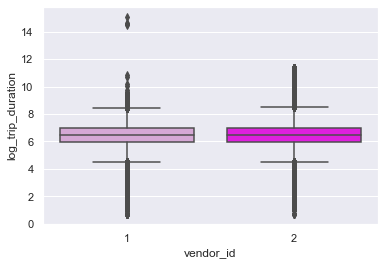

In [1255]:
ax = sns.boxplot(x='vendor_id', y="log_trip_duration", data=df, palette = ['plum', 'magenta'])

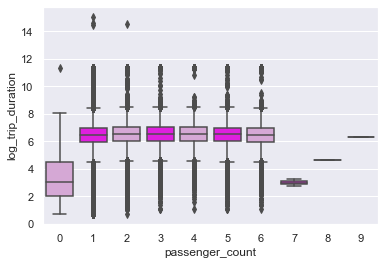

In [1256]:
ax = sns.boxplot(x='passenger_count', y="log_trip_duration", data=df, palette = ['plum', 'magenta'])

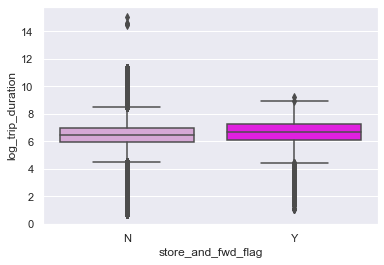

In [1257]:
ax = sns.boxplot(x='store_and_fwd_flag', y="log_trip_duration", data=df, palette = ['plum', 'magenta'])

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [1258]:
df.vendor_id -=1
df.store_and_fwd_flag = (df.store_and_fwd_flag == 'Y').astype(int)


**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

**Ответ**: Поездок с количеством пассажиров меньше 6 таргеты будут одинаковые примерно, поездок с кол-вом больше 6 мало, потом видимо как выбросы будем их убирать, поездок с 0 пассажирами это видимо доставки -- признак сильный имеет смысл выделить как отдельный. Остальные признаки слабые и нам не нужны


In [1259]:
df.loc[:,'is_delivery'] = (df['passenger_count'] == 0).apply(lambda x: 1 if x else 0)

In [1260]:
st = StandardScaler()
oh = OneHotEncoder()
df_new = df.reset_index().drop('index', axis=1)
StandardScal = pd.DataFrame(st.fit_transform(df[['is_snow', 'month', 'is_memorial']]))
StandardScal.columns = ['is_snow', 'month', 'is_memorial']
oh = pd.DataFrame(oh.fit_transform(df[['hour', 'weekday', 'day']]).toarray())
df_new = df_new.join(oh)

In [1261]:
columns_to_drop = ['id', 'pickup_datetime']
df_new.drop(inplace=True, columns=columns_to_drop)


**Задание 12 (0.25 баллов)**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [1262]:
train1, test1 = train_test_split(df_new, test_size=0.3, random_state=10)
x1 = train1.loc[:,'log_trip_duration']
y1 = test1.loc[:,'log_trip_duration']
columns_to_drop = ['log_trip_duration']
train1.drop(inplace=True, columns=columns_to_drop)
test1.drop(inplace=True, columns=columns_to_drop)
regressor = Ridge()
regressor.fit(train1, x1)
y_pred = regressor.predict(test1)
print("Test MSE = %.10f" % ((mean_squared_error(y1, y_pred))))

/Users/varya/miniforge3/envs/hseml/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Test MSE = 0.2068091010


In [1263]:
columns_to_drop = ['store_and_fwd_flag', 'vendor_id']
df_new.drop(inplace=True, columns=columns_to_drop)

In [1264]:
train1, test1 = train_test_split(df_new, test_size=0.3, random_state=10)
x1 = train1.loc[:,'log_trip_duration']
y1 = test1.loc[:,'log_trip_duration']
columns_to_drop = ['log_trip_duration']
train1.drop(inplace=True, columns=columns_to_drop)
test1.drop(inplace=True, columns=columns_to_drop)
regressor = Ridge()
regressor.fit(train1, x1)
y_pred = regressor.predict(test1)
print("Test MSE = %.10f" % ((mean_squared_error(y1, y_pred))))

/Users/varya/miniforge3/envs/hseml/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Test MSE = 0.2068202176


Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

Хочу выбросить эти store_and_fwd_flag и vendor_id по боксплотам они не нужны

мсе почти не отличается, значит выкинули и забыли. 

## Часть 4. Улучшаем модель (3 балла)

**Задание 13 (1 балл)**. В наших данных есть нетипичные объекты: с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите обучающую выборку от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

**Ответ**: из первой гистограммы части 0 задания 1 ясно что в основном log_trip_duration от 4 до 9. значит что не в диапазоне -- выброс. убираем. вторая гистограмма показывает что в целом меньше 3.5 ок, остальное убираем, третья гистограмма

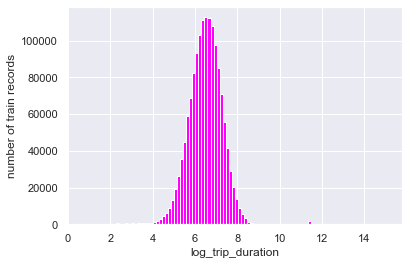

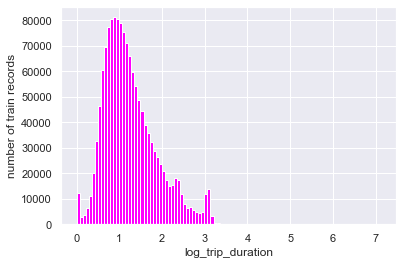

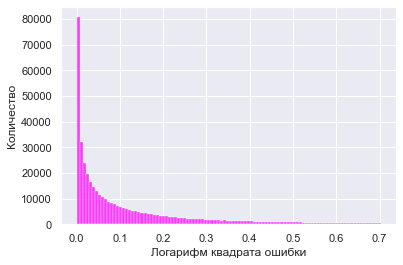

In [1265]:
#время поездки
df['log_trip_duration'] = np.log1p(df['trip_duration'].values)
plt.hist(df['log_trip_duration'].values, bins=100, color='magenta')
plt.xlabel('log_trip_duration')
plt.ylabel('number of train records')
plt.show()
#пройденное расстояние
plt.hist(df['log_haversine'].values, bins=100, color='magenta')
plt.xlabel('log_trip_duration')
plt.ylabel('number of train records')
plt.show()
#остатки регресии
error = (y1 - y_pred) ** 2
sns.histplot(error[error < error.quantile(0.95)], bins=100, color='magenta')
plt.xlabel('Логарифм квадрата ошибки')
plt.ylabel('Количество')
plt.show()

In [1266]:
df_new = df_new[(error < error.quantile(0.95)) & (df_new['log_trip_duration'] > 4) & (df_new['log_haversine'] < 3.5)]

In [1267]:
df_new.drop(inplace=True, columns=['weekday', 'day', 'hour', 
                                    'dropoff_longitude', 'dropoff_latitude',
                                    'pickup_longitude', 'pickup_latitude',
                                    'trip_duration'])

In [1268]:
train1, test1 = train_test_split(df_new, test_size=0.3, random_state=10)
x1 = train1.loc[:,'log_trip_duration']
y1 = test1.loc[:,'log_trip_duration']
columns_to_drop = ['log_trip_duration']
train1.drop(inplace=True, columns=columns_to_drop)
test1.drop(inplace=True, columns=columns_to_drop)
regressor = Ridge()
regressor.fit(train1, x1)
y_pred = regressor.predict(test1)
print("Test MSE = %.10f" % ((mean_squared_error(y1, y_pred))))

/Users/varya/miniforge3/envs/hseml/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Test MSE = 0.1177082510


Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Попробуйте объединить редкие категории в одну. Естественно, делать это нужно только для действительноредких категорий.



In [1269]:
df_new.head(2)

,passenger_count,log_trip_duration,haversine,log_haversine,is_trafic,is_free,pickup_lag,dropoff_lag,pickup_ken,dropoff_ken,...,203,204,205,206,207,208,209,210,211,212
0,1,6.122493,1.498521,0.915699,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,6.063785,1.485498,0.910473,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1270]:
df_new[df_new.columns[-213:]].sum(axis=0)

0      15122.0
1      10932.0
2       8137.0
3       6046.0
4       4495.0
        ...   
208     1993.0
209     2100.0
210     2072.0
211     2074.0
212     2169.0
Length: 213, dtype: float64

In [1271]:
# час
df_new[df_new.columns[-213: -213 + 24]].sum(axis=0)

0     15122.0
1     10932.0
2      8137.0
3      6046.0
4      4495.0
5      4406.0
6      9766.0
7     15837.0
8     19077.0
9     19319.0
10    18599.0
11    19264.0
12    20001.0
13    20102.0
14    20908.0
15    20172.0
16    18058.0
17    21556.0
18    26011.0
19    25802.0
20    24301.0
21    24381.0
22    23196.0
23    20068.0
dtype: float64

Объединим 2-6 ночи

In [1272]:
df_new.loc[:, 'night'] = df_new.loc[:, 2] + df_new.loc[:, 3] + df_new.loc[:, 4] \
                            + df_new.loc[:, 5] + df_new.loc[:, 6]

In [1273]:
df_new.head(2)

,passenger_count,log_trip_duration,haversine,log_haversine,is_trafic,is_free,pickup_lag,dropoff_lag,pickup_ken,dropoff_ken,...,204,205,206,207,208,209,210,211,212,night
0,1,6.122493,1.498521,0.915699,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,6.063785,1.485498,0.910473,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1274]:
df_new[df_new.columns[-214 + 24: -214 + 24 + 7]].sum(axis=0)

24    53573.0
25    57952.0
26    59828.0
27    62363.0
28    63365.0
29    62433.0
30    56042.0
dtype: float64

День недели оставим без изменений

In [1275]:
df_new[df_new.columns[-214 + 24 + 7: -1]].sum(axis=0).mean()

2283.2747252747254

Признаки по дням объединим в один если в нем меньше 500 поездок

In [1276]:
columns = df_new[df_new.columns[-214 + 24 + 7: -1]].sum(axis=0) < 500

In [1277]:
rare_columns = df_new.columns[-214 + 24 + 7: -1][columns]

In [1278]:
rare_columns

Index([53], dtype='object')

In [1279]:
df_new['rare_days'] = df_new[rare_columns].sum(axis=1)

In [1280]:
df_drop = df_new.drop(columns=[2, 3, 4, 5, 33, 53, 54, 55, 181])

Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

In [1296]:
train1, test1 = train_test_split(df_drop, test_size=0.3, random_state=10)
x1 = train1.loc[:,'log_trip_duration']
y1 = test1.loc[:,'log_trip_duration']

columns_to_drop = ['log_trip_duration']

train1.drop(inplace=True, columns=columns_to_drop)
test1.drop(inplace=True, columns=columns_to_drop)

regressor = Ridge()
regressor.fit(train1, x1)
y_pred = regressor.predict(test1)
print("Ridge Test MSE = %.10f" % ((mean_squared_error(y1, y_pred))))

/Users/varya/miniforge3/envs/hseml/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Ridge Test MSE = 0.1180901923


**Задание 14 (1 балл)**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [1281]:
len(df.columns), len(df.columns) + len(ohe.get_feature_names())

(26, 239)

Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?

In [1282]:
from sklearn.linear_model import Lasso

In [1284]:
train1, test1 = train_test_split(df_drop, test_size=0.3, random_state=10)
x1 = train1.loc[:,'log_trip_duration']
y1 = test1.loc[:,'log_trip_duration']

columns_to_drop = ['log_trip_duration']

train1.drop(inplace=True, columns=columns_to_drop)
test1.drop(inplace=True, columns=columns_to_drop)

regressor = Lasso()
regressor.fit(train1, x1)
y_pred = regressor.predict(test1)
print("Lasso Test MSE = %.10f" % ((mean_squared_error(y1, y_pred))))

regressor = Ridge()
regressor.fit(train1, x1)
y_pred = regressor.predict(test1)
print("Ridge Test MSE = %.10f" % ((mean_squared_error(y1, y_pred))))

/Users/varya/miniforge3/envs/hseml/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Lasso Test MSE = 0.3122651766
Ridge Test MSE = 0.1180901923


Lasso сработало хуже

Разбейте обучающую выборку на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерьте качество лучшей полученной модели.

In [1285]:
train, valid, y_train, y_valid = train_test_split(train1, x1, test_size=0.2)

In [1286]:
from sklearn.model_selection import GridSearchCV

Lasso:

In [1287]:
alphas = np.logspace(-4, -1, 10)
searcher = GridSearchCV(Lasso(), {"alpha": alphas}, cv=5)

searcher.fit(train, y_train)
b_alpha = searcher.best_params_['alpha']

print("Best alpha = %.4f" % b_alpha)

Best alpha = 0.0001


In [1288]:
y_pred = searcher.predict(test1)
print("Test MSE = %.10f" % ((mean_squared_error(y1, y_pred))))

Test MSE = 0.1186304451


Ridge:

In [1289]:
alphas = np.logspace(-4, -1, 10)
searcher = GridSearchCV(Ridge(), {"alpha": alphas}, cv=5)

searcher.fit(train, y_train)
b_alpha = searcher.best_params_['alpha']

print("Best lambda = %.4f" % b_alpha)

y_pred = searcher.predict(test1)
print("Test MSE = %.10f" % ((mean_squared_error(y1, y_pred))))

Best lambda = 0.1000
Test MSE = 0.1181178238


Для каждого перебранного `alpha` для Lasso посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков?

In [1290]:
alphas = np.logspace(-4, -1, 10)
n_zeros = []
for alpha in alphas:
    reg = Lasso(alpha)
    reg.fit(train, y_train)
    n_zeros.append(np.sum(reg.coef_ == 0))

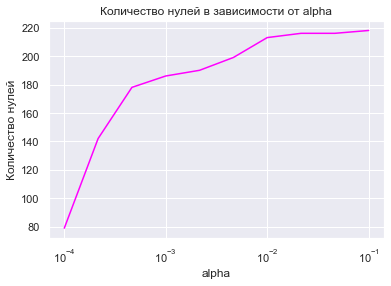

In [1291]:
plt.plot(alphas, n_zeros, color='magenta')
plt.xscale('log')
plt.title('Количество нулей в зависимости от alpha')
plt.xlabel('alpha')
plt.ylabel('Количество нулей')
plt.show()

In [1292]:
train.shape[1] / 2

109.5

In [1293]:
reg = Lasso(0.0002)
reg.fit(train, y_train)
np.sum(reg.coef_ == 0)

141

In [1294]:
y_pred = reg.predict(test1)
print("Test MSE = %.10f" % ((mean_squared_error(y1, y_pred))))

Test MSE = 0.1190605429


В качестве мы не потеряли потому что признаков и так очень много (не понимаю зачем нужны признаки "день в году", которых 170 из 228)

<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 15 (1 балл)**. Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту Манхэттена на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими частыми парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

Также можете придумать ещё какой-нибудь способ сделать признаки про маршрут. Если эти признаки будут давать хороший прирост в качестве, то за это могут быть даны дополнительные бонусные баллы.

**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно "вытащить" эту информацию, ведь у нее в распоряжении есть признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка"?

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Заново обучите модель (`Ridge`, если она дала более высокое качество в предыдущих экспериментах, и `Lasso` иначе) на новых даннных и посчитайте качество на тестовой выборке

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 16 (бонус, 1 балл)**. Где, как не для нашей задачи, считать манхэттенское расстояние?

**Вопрос**: Найдите, что такое манхэттенское расстояние и почему оно так называется. Как оно нам может помочь?

Введите систему координат на нашей карте так, чтобы оси были параллельны улицам Манхэттена, и добавьте сначала в данные признак "манхэттенское расстояние между пунктом отправления и пунктом назначения", а затем и логарифм этого признака. Посчитайте корреляцию между вашим новыми признаком и таргетом; между `log_haversine` и таргетом. В каком случае корреляция больше?

Нарисуйте карту, где покажете выбранные оси. Чтобы мы могли проверить вашу работу, просьба сделать скрин этой карты и приложить картинку (если мы откроем ваш ноутбук, виджеты отображаться не будут). 

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Заново обучите модель на новых даннных и посчитайте качество на тестовой выборке. Стало ли лучше? Объясните полученный результат.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 17 (бонус, 2 балла)**. Реализуйте трансформер, который строит разбиение карты по шестигранной решётке с помощью библиотеки [H3](https://github.com/uber/h3-py) и вычисляет признаки на основе такого разбиения.

Признаки могут быть самые разные: расстояние между точкой старта и финиша, посчитанное в количестве шестиугольников; статистика по числу поездок и по их продолжительности в соседних шестиугольниках.

Важно: производительность библиотеки существенно зависит от количества шестиугольников на карте (определяется параметром resolution). Подберите такое разрешение, при котором ваш код будет работать за приемлемое время.

При построении признаков старайтесь не допустить утечки целевой переменной (подробнее про это можно почитать в материалах 1-го семинара) — в противном случае хорошего качества на тестовой выборке достичь не получится.

Измерьте качество после добавления новых признаков. За улучшение функционала ошибки на каждые 0.005 на тестовой выборке будет даваться 0.5 бонусных балла. Можно получить до 2 бонусных баллов за это задание.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.